In [11]:
import pprint
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as stats
import folium
from folium.plugins import MarkerCluster, HeatMap

plt.style.use('ggplot')
%matplotlib inline

In [6]:
bar_cols = ['id', 'alias', 'name', 'review_count', 'rating', 'lat', 'lng', 
                'addr1', 'addr2', 'addr3', 'city', 'zip', 'country', 'state']
brs = pd.read_csv('data/bar_data.csv', sep='\t', names=bar_cols).drop_duplicates(subset='alias')

In [4]:
all_cols = ['incident','offense_descr','offense_code','fam_violence','occurred_date_time',
                'occurred_date','occurred_time','report_date_time','report_date','report_time',
                'location_type','address','zip','district','apd_sector','apd_district','pra',
                'census_tract','clearance_status','clearance_date','ucr_category','category_descr',
                'x_coord','y_coord','lat','lng','location']
use_cols = ['offense_descr','occurred_date','occurred_time','report_date','category_descr','lat','lng']

crm = pd.read_csv('data/police_data.csv', names=all_cols, usecols=use_cols)
print(crm.count())
# crm = crm[['offense_descr','occurred_date','report_date','category_descr','lat','lng']]
crm['occurred_date'] = pd.to_datetime(crm['occurred_date'])
crm['year'] = crm['occurred_date'].dt.year
crm = crm[crm['year'] >= 2016]
crm = crm[~crm['lat'].isnull()]
print(crm.count())

offense_descr     2197125
occurred_date     2197125
occurred_time     2197041
report_date       2197125
category_descr     743765
lat               2159885
lng               2159885
dtype: int64
offense_descr     421433
occurred_date     421433
occurred_time     421433
report_date       421433
category_descr    145710
lat               421433
lng               421433
year              421433
dtype: int64


In [7]:
print(f'There are {brs["alias"].count()} bars in Austin')

There are 797 bars in Austin


/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


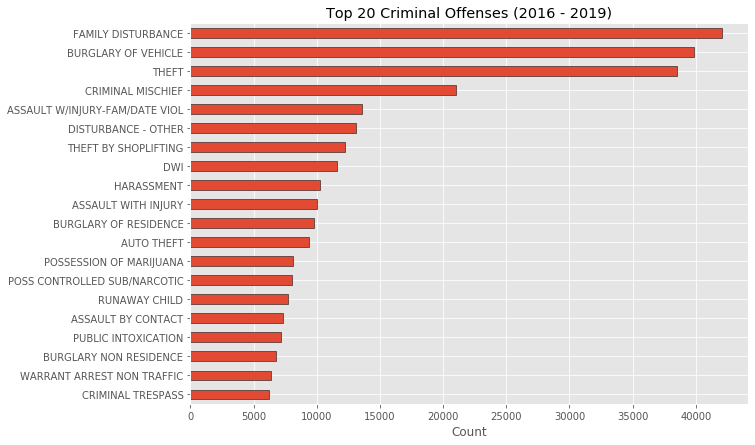

In [165]:
off_desc = crm[['offense_descr', 'occurred_date']].groupby('offense_descr')\
            .count().sort_values('occurred_date', ascending=False).rename(columns={'occurred_date': 'count'})
plot = off_desc.iloc[:20].plot.barh(y='count', figsize=(10,7), legend=False, edgecolor='k')
_ = plt.xlabel('Count')
_ = plt.title('Top 20 Criminal Offenses (2016 - 2019)')

ax1 = plt.axes()
y_ax = ax1.axes.get_yaxis()
y_ax.label.set_visible(False)

plt.gca().invert_yaxis()

In [25]:
# print(br[['incident','occurred_date']].max())
# print(br[['incident','occurred_date']].min())

# pub_int = crm[crm['offense_descr'] == 'PUBLIC INTOXICATION']
# pub_int = pub_int[~pub_int['lat'].isnull()]

In [91]:
bar_map = folium.Map(location=['30.26499', '-97.74658'], tiles='Stamen Terrain', zoom_start=11)
HeatMap(data=brs[['lat','lng']].values.tolist(), radius=10, max_zoom=13).add_to(bar_map)
bar_map

In [26]:
map_df = crm[crm['offense_descr'] == 'PUBLIC INTOXICATION'].loc[:, ('occurred_date', 'lat', 'lng')]
sub_setmap = map_df[:10000]
austin_map = folium.Map(location=['30.26499', '-97.74658'], tiles='Stamen Terrain', zoom_start=11)
# austin_map = folium.Map(location=['30.26499', '-97.74658'], zoom_start=11)

HeatMap(data=sub_setmap[['lat', 'lng']].values.tolist(), radius=7, max_zoom=13).add_to(austin_map)
austin_map

In [27]:
def bars_in_box(upper, lower, left, right, df):
    return df[(df['lat'] > lower) & (df['lat'] <= upper) & \
                 (df['lng'] > left) & (df['lng'] <= right)]['lat'].count()

In [40]:
def get_bars_from_grid(df, tl, tr, bl, br, step=.002):
    topleft_lat = tl[0]
    topleft_lng = tl[1]
    bars_in_grid = []
    
    while topleft_lat + step > bl[0]:
        if topleft_lng + step > tr[1]:
            topleft_lng = tl[1]
            topleft_lat -= step
        while topleft_lng + step < tr[1]:
            bars_in_grid.append(bars_in_box(topleft_lat, topleft_lat - step, topleft_lng, topleft_lng + step, df))
            topleft_lng += step
    
    return bars_in_grid

In [41]:
def get_bars_from_crimes(df1, crimes, col='PUBLIC INTOXICATION', step=.002):
    df2 = crimes[crimes['offense_descr'] == col].loc[:, ('lat', 'lng')]
    step = .002
    bars_in_range = []
    for index, row in df2.iterrows():
        if row['lat'] <= tl[0] and row['lat'] > br[0] and row['lng'] >= tl[1] and row['lng'] < br[1]:
            bars = bars_in_box(row['lat'] + step/2, row['lat'] - step/2, row['lng'] - step/2, row['lng'] + step/2, df1)
            bars_in_range.append(bars)
    
    return bars_in_range

In [29]:
# print(bars_in_box(tl[0], tl[0]-20*step, tl[1], tr[1], brs[['lat','lng']]))
# print(bars_in_box(tl[0], bl[0], tl[1], tr[1], brs[['lat','lng']]))# gets all bars in area
# print(bars_in_box(tl[0], bl[0]-.002, tl[1], tr[1]+.002, brs[['lat','lng']]))# gets all bars in area + padding

There are 348 bars in the region
There's an average 0.2954 per subregion


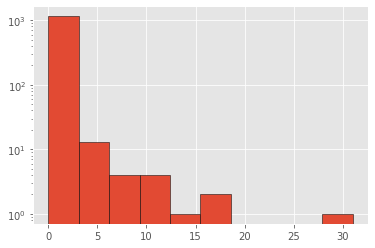

In [170]:
tl = 30.3335, -97.7707
tr = 30.3335, -97.7077
bl =  30.2631, -97.7707
br = 30.2631, -97.7077


bars_in_grid = get_bars_from_grid(brs[['lat','lng']], tl, tr, bl, br)
bars_mean = np.mean(bars_in_grid)
print(f'There are {np.sum(bars_in_grid)} bars in the region')
print(f'There\'s an average {bars_mean:1.4f} per subregion')

fig, ax = plt.subplots()
plot = ax.hist(bars_in_grid, edgecolor='k')
plt.yscale('log')

# Note: Passing through the whole region as one yields 289 bars
# while iterating yields 348.

In [99]:
top_20 = off_desc.reset_index().loc[:20-1, ['offense_descr']].values.ravel()
print(top_20)

offense_data = {}
for offense in top_20:
    bar_counts = get_bars_from_crimes(brs, crm, offense)
    data = {'data': bar_counts}
    offense_data[offense] = data
    
    t_stat, pval = stats.ttest_1samp(bar_counts, bars_mean)
    offense_data[offense]['t stat'] = t_stat
    offense_data[offense]['pvalue'] = pval
    offense_data[offense]['mean'] = np.mean(bar_counts)

['FAMILY DISTURBANCE' 'BURGLARY OF VEHICLE' 'THEFT' 'CRIMINAL MISCHIEF'
 'ASSAULT W/INJURY-FAM/DATE VIOL' 'DISTURBANCE - OTHER'
 'THEFT BY SHOPLIFTING' 'DWI' 'HARASSMENT' 'ASSAULT WITH INJURY'
 'BURGLARY OF RESIDENCE' 'AUTO THEFT' 'POSSESSION OF MARIJUANA'
 'POSS CONTROLLED SUB/NARCOTIC' 'RUNAWAY CHILD' 'ASSAULT BY CONTACT'
 'PUBLIC INTOXICATION' 'BURGLARY NON RESIDENCE'
 'WARRANT ARREST NON TRAFFIC' 'CRIMINAL TRESPASS']


Text(0.5, 0.98, 'Number of Bars Near Crimes')

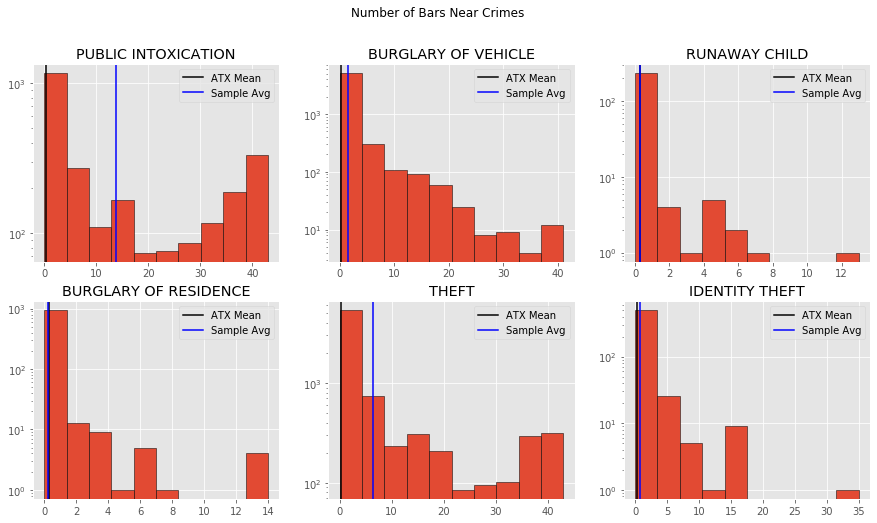

In [33]:
top_offenses = ['PUBLIC INTOXICATION', 'BURGLARY OF VEHICLE', 'RUNAWAY CHILD', \
                'BURGLARY OF RESIDENCE', 'THEFT', 'IDENTITY THEFT']
fig, axes = plt.subplots(2,3, figsize=(15,8))

t_stats = []
pvals = []
sample_means = []

for ax, cat in zip(axes.flatten(), top_offenses):
    data = get_bars_from_crimes(brs, crm, cat)
    ax.hist(data, edgecolor='k')
    ax.axvline(bars_mean, c='k', label='ATX Mean')
    ax.axvline(np.mean(data), c='b', label='Sample Avg')
    ax.set_title(cat)
    ax.set_yscale('log')
    ax.legend()
    
    t_stat, pval = stats.ttest_1samp(data, bars_mean)
    pvals.append(pval)
    t_stats.append(t_stat)
    sample_means.append(np.mean(data))

plt.suptitle("Number of Bars Near Crimes")
# plt.title()
# plt.legend()

In [171]:
alpha = 0.05
n_tests = len(top_20)
adj_alpha = alpha/n_tests

print(f'adj significance level is: {adj_alpha:1.4f}\n')
for c_type, c_dict in offense_data.items():
    print(f'''{c_type}:\n\tpval: {c_dict['pvalue']:1.4f}\n\ttest statistic: {c_dict['t stat']:1.3f}\
        \n\tsample size: {len(c_dict['data'])}\n\tmean: {c_dict['mean']:1.3f}''')

adj significance level is: 0.0025

FAMILY DISTURBANCE:
	pval: 0.0000
	test statistic: 15.931        
	sample size: 3196
	mean: 1.969
BURGLARY OF VEHICLE:
	pval: 0.0000
	test statistic: 23.408        
	sample size: 5775
	mean: 1.594
THEFT:
	pval: 0.0000
	test statistic: 46.736        
	sample size: 7753
	mean: 6.435
CRIMINAL MISCHIEF:
	pval: 0.0000
	test statistic: 20.588        
	sample size: 3451
	mean: 2.618
ASSAULT W/INJURY-FAM/DATE VIOL:
	pval: 0.0000
	test statistic: 11.732        
	sample size: 1210
	mean: 2.526
DISTURBANCE - OTHER:
	pval: 0.0000
	test statistic: 24.120        
	sample size: 2080
	mean: 6.130
THEFT BY SHOPLIFTING:
	pval: 0.0000
	test statistic: 7.815        
	sample size: 1531
	mean: 0.907
DWI:
	pval: 0.0000
	test statistic: 24.302        
	sample size: 3114
	mean: 3.525
HARASSMENT:
	pval: 0.0000
	test statistic: 7.779        
	sample size: 1262
	mean: 1.029
ASSAULT WITH INJURY:
	pval: 0.0000
	test statistic: 40.097        
	sample size: 3012
	mean: 9.749
BURGLAR

In [152]:
sample_means = {}
for k, v in offense_data.items():
    sample_means[k] = v['mean']

C0


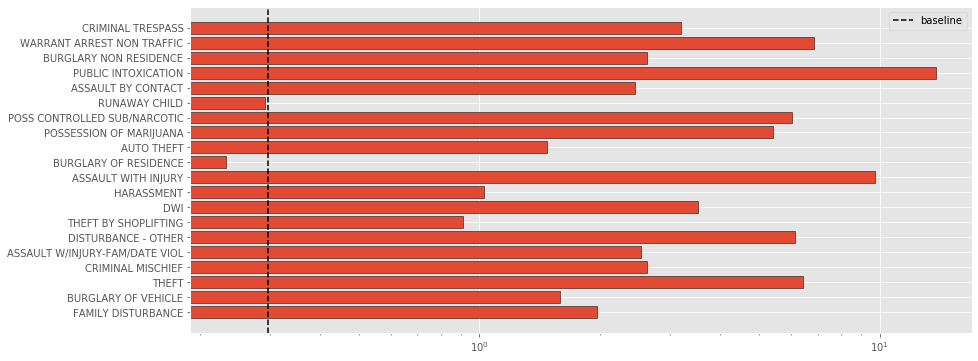

In [176]:
import matplotlib as mpl
print(mpl.rcParams['lines.color'])

fig, ax = plt.subplots(figsize=(14, 6))

# clr = ['orange' if v['pvalue'] < adj_alpha else 'gray' for v in offense_data.values()]

_ = ax.barh(range(n_tests), list(sample_means.values()), tick_label=list(sample_means.keys()), 
            edgecolor='k')
_ = ax.set_xscale('log')
_ = ax.axvline(bars_mean, c='k', linestyle='--', label='baseline')
_ = plt.legend()